In [1]:
!pip install -U sagemaker

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install transformers==4.17.0

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PyYAML-6.0.dist-info/METADATA'

You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [3]:
import json

import sagemaker
import sagemaker.huggingface
from sagemaker.huggingface import HuggingFace, TrainingCompilerConfig

sess = sagemaker.Session()
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

In [4]:
# metric definition to extract the results
metric_definitions = [
    {"Name": "train_runtime", "Regex": "train_runtime.*=\D*(.*?)$"},
    {"Name": "train_samples_per_second", "Regex": "train_samples_per_second.*=\D*(.*?)$"},
    {"Name": "epoch", "Regex": "epoch.*=\D*(.*?)$"},
    {"Name": "f1", "Regex": "f1.*=\D*(.*?)$"},
    {"Name": "exact_match", "Regex": "exact_match.*=\D*(.*?)$"},
]

# instance configurations
instance_type = "ml.p3.16xlarge"
instance_count = 3
volume_size = 200

## Training with Native PyTorch

In [5]:
with open("native/config.json") as f:
    config = json.loads(f.read())

role = config["aws_config"]["role"]
smp_options = config["smp_options"]
mpi_options = config["mpi_options"]
hyperparameters = config["hyperparameters"]
distribution = {"smdistributed": {"modelparallel": smp_options}, "mpi": mpi_options}
# distribution = {"smdistributed": {"dataparallel": {"enabled": True}}}

In [6]:
native_estimator = HuggingFace(
    entry_point="native/run_mlm.py",
    metrics_definition=metric_definitions,
    instance_type=instance_type,
    instance_count=instance_count,
    volume_size=volume_size,
    role=role,
    transformers_version="4.17",
    pytorch_version="1.10",
    py_version="py38",
    distribution=distribution,
    hyperparameters=hyperparameters,
    disable_profiler=True,  # Disable SageMaker Profiler to avoid overhead during benchmarking
    debugger_hook_config=False,  # Disable SageMaker Debugger to avoid overhead during benchmarking
)

# print(huggingface_estimator.hyperparameters())
# starting the train job with our uploaded datasets as input
native_estimator.fit(wait=False)
native_estimator.latest_training_job.name

'huggingface-pytorch-training-2022-05-17-13-40-15-133'

## Training with Optimized PyTorch

In [7]:
with open("native/config.json") as f:
    config = json.loads(f.read())

role = config["aws_config"]["role"]
smp_options = config["smp_options"]
mpi_options = config["mpi_options"]
hyperparameters = config["hyperparameters"]
# distribution = {"smdistributed": {"modelparallel": smp_options}, "mpi": mpi_options}
# distribution = {"smdistributed": {"dataparallel": {"enabled": True}}}

In [8]:
# Enable the training compiler.
compiler_config = TrainingCompilerConfig()

# To use SageMaker Training Compiler in a Distributed setting, please use a wrapper script to invoke your training script
LAUNCH_SM_TRAINING_COMPILER = "launch_sm_training_compiler.py"
SORCE_DIR = "./optimized"
hyperparameters["training_script"] = "optimized/run_mlm.py"

optimized_estimator = HuggingFace(
    entry_point=LAUNCH_SM_TRAINING_COMPILER,
    source_dir=SORCE_DIR,
    compiler_config=compiler_config,
    metrics_definition=metric_definitions,
    instance_type=instance_type,
    instance_count=instance_count,
    volume_size=volume_size,
    role=role,
    transformers_version="4.17",
    pytorch_version="1.10",
    py_version="py38",
    # distribution=distribution,
    hyperparameters=hyperparameters,
    disable_profiler=True,  # Disable SageMaker Profiler to avoid overhead during benchmarking
    debugger_hook_config=False,  # Disable SageMaker Debugger to avoid overhead during benchmarking
)

# print(huggingface_estimator.hyperparameters())
# starting the train job with our uploaded datasets as input
optimized_estimator.fit(wait=False)
optimized_estimator.latest_training_job.name

'huggingface-pytorch-trcomp-training-2022-05-17-14-23-20-133'

In [9]:
waiter = native_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=native_estimator.latest_training_job.name)
waiter = optimized_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=optimized_estimator.latest_training_job.name)

NameError: name 'native_estimator' is not defined

## Analysis

In [13]:
%%capture optimized


import sagemaker
# access the logs of the optimized training job
# optimized_estimator.sagemaker_session.logs_for_job(optimized_estimator.latest_training_job.name)
optimized_estimator = sagemaker.estimator.Estimator.attach("huggingface-pytorch-training-2022-05-16-14-34-15-347")

In [14]:
%%capture native

# access the logs of the native training job
# native_estimator.sagemaker_session.logs_for_job(native_estimator.latest_training_job.name)
native_estimator = sagemaker.estimator.Estimator.attach("huggingface-pytorch-training-2022-05-16-14-34-13-504")

In [15]:
from ast import literal_eval
from collections import defaultdict
from matplotlib import pyplot as plt


def _summarize(captured):
    final = []
    for line in captured.stdout.split("\n"):
        cleaned = line.strip()
        if "{" in cleaned and "}" in cleaned:
            final.append(cleaned[cleaned.index("{") : cleaned.index("}") + 1])
    return final


def make_sense(string):
    try:
        return literal_eval(string)
    except:
        pass


def summarize(summary):
    final = {"train": [], "eval": [], "summary": {}}
    for line in summary:
        interpretation = make_sense(line.replace("nan", "'nan'"))
        if interpretation:
            if "loss" in interpretation:
                final["train"].append(interpretation)
            elif "eval_loss" in interpretation:
                final["eval"].append(interpretation)
            elif "train_runtime" in interpretation:
                final["summary"].update(interpretation)
    return final

In [17]:
n = summarize(_summarize(native))

In [19]:
_summarize(native)

[]

### Plot Optimized vs Native Training Throughput

In [16]:
# Average throughput for the native PyTorch training as reported by Trainer
n = summarize(_summarize(native))
native_throughput = n["summary"]["train_samples_per_second"]

# Average throughput for the optimized PyTorch training as reported by Trainer
o = summarize(_summarize(optimized))
optimized_throughput = o["summary"]["train_samples_per_second"]

# Calculate percentage speedup of optimized PyTorch over native PyTorch
avg_speedup = f"{round((optimized_throughput/native_throughput-1)*100)}%"

KeyError: 'train_samples_per_second'

NameError: name 'native_throughput' is not defined

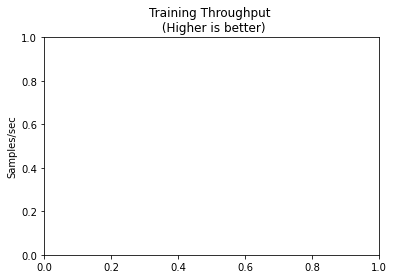

In [20]:
%matplotlib inline

plt.title("Training Throughput \n (Higher is better)")
plt.ylabel("Samples/sec")

plt.bar(x=[1], height=native_throughput, label="Baseline PT", width=0.35)
plt.bar(x=[1.5], height=optimized_throughput, label="Compiler-enhanced PT", width=0.35)

plt.xlabel("  ====> {} Compiler savings <====".format(avg_speedup))
plt.xticks(ticks=[1, 1.5], labels=["Baseline PT", "Compiler-enhanced PT"])

### Convergence of Training Loss

In [ ]:
vanilla_loss = [i["loss"] for i in n["train"]]
vanilla_epochs = [i["epoch"] for i in n["train"]]
optimized_loss = [i["loss"] for i in o["train"]]
optimized_epochs = [i["epoch"] for i in o["train"]]

plt.title("Plot of Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(vanilla_epochs, vanilla_loss, label="Baseline PT")
plt.plot(optimized_epochs, optimized_loss, label="Compiler-enhanced PT")
plt.legend()

In [7]:
### Training Stats

In [8]:
pd.DataFrame([n["summary"], o["summary"]], index=["Native", "Compiler-enhanced"])
speedup = (
    (n["summary"]["train_runtime"] - o["summary"]["train_runtime"])
    * 100
    / n["summary"]["train_runtime"]
)
print(
    f"SageMaker Training Compiler is about {int(speedup)}% faster in terms of total training time."
)

NameError: name 'pd' is not defined

### Total Billable Time

In [ ]:
def BillableTimeInSeconds(name):
    describe_training_job = (
        optimized_estimator.sagemaker_session.sagemaker_client.describe_training_job
    )
    details = describe_training_job(TrainingJobName=name)
    return details["BillableTimeInSeconds"]

In [ ]:
Billable = {}
Billable["Native"] = BillableTimeInSeconds(native_estimator.latest_training_job.name)
Billable["Optimized"] = BillableTimeInSeconds(optimized_estimator.latest_training_job.name)
pd.DataFrame(Billable, index=["BillableSecs"])

In [ ]:
speedup = (Billable["Native"] - Billable["Optimized"]) * 100 / Billable["Native"]
print(f"SageMaker Training Compiler integrated PyTorch was {int(speedup)}% faster in summary.")

## Clean Up

In [ ]:
import boto3

sm = boto3.client("sagemaker")


def stop_training_job(name):
    status = sm.describe_training_job(TrainingJobName=name)["TrainingJobStatus"]
    if status == "InProgress":
        sm.stop_training_job(TrainingJobName=name)


stop_training_job(native_estimator.latest_training_job.name)
stop_training_job(optimized_estimator.latest_training_job.name)